In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder

|Name|Descr|
|----|-----|
| Id |	To count the records | 
|MSSubClass|	 Identifies the type of dwelling involved in the sale|
|MSZoning|	Identifies the general zoning classification of the sale|
|LotArea|	 Lot size in square feet|
|LotConfig|	Configuration of the lot|
|BldgType|Type of dwelling|
|OverallCond|	Rates the overall condition of the house|
|YearBuilt|	Original construction year|
|YearRemodAdd|	Remodel date (same as construction date if no remodeling or additions)|
|Exterior1st|	Exterior covering on house|
|BsmtFinSF2|	Type 2 finished square feet|
|TotalBsmtSF|	Total square feet of basement area|
|SalePrice|	To be predicted|

In [2]:
data = pd.read_excel('HousePricePrediction.xlsx')
def clean_data(data):
    # Replace missing values with the median of each column in: 'BsmtFinSF2', 'TotalBsmtSF', 'SalePrice'
    data = data.fillna({'BsmtFinSF2': data['BsmtFinSF2'].median(), 'TotalBsmtSF': data['TotalBsmtSF'].median(), 'SalePrice': data['SalePrice'].median()})
    # Replace missing values with the most common value of each column in: 'Exterior1st', 'MSZoning'
    data = data.fillna({'Exterior1st': data['Exterior1st'].mode()[0], 'MSZoning': data['MSZoning'].mode()[0]})
    return data

data = clean_data(data.copy())
data = data.drop('Id',axis=1)

<Axes: >

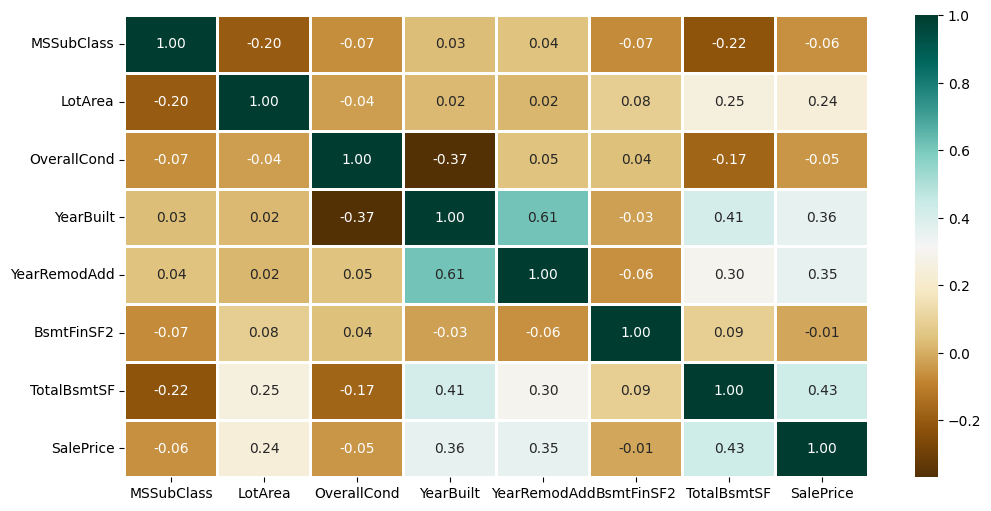

In [3]:
numerical_dataset = data.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))
sns.heatmap(numerical_dataset.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

In [4]:
OH_encode = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encode.fit_transform(data[['MSZoning','LotConfig','BldgType','Exterior1st']]))
OH_cols.index = data.index
OH_cols.columns = OH_encode.get_feature_names_out()
data_cleaned = data.drop(['MSZoning','LotConfig','BldgType','Exterior1st'],axis=1)
data_cleaned = pd.concat([data_cleaned,OH_cols],axis=1)

ShapiroResult(statistic=np.float64(0.6984593774740281), pvalue=np.float64(3.24486633615635e-58))


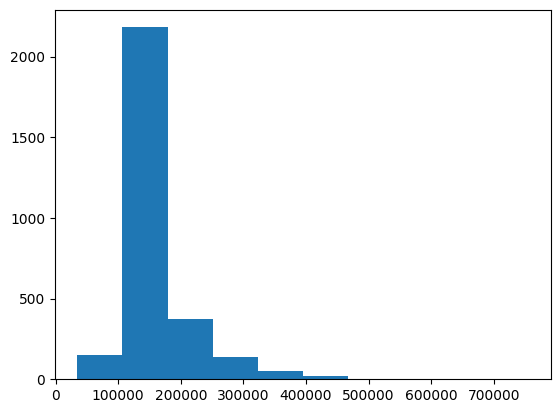

In [5]:
import math
from matplotlib import scale
from scipy.stats import shapiro

print(shapiro(data_cleaned['SalePrice']))
plt.hist(data_cleaned['SalePrice'])
plt.show()

In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

X = data_cleaned.drop(['SalePrice'], axis=1)
Y = data_cleaned['SalePrice']

X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)
print('MAPE Comparision:')

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_valid)
print('SVM: ')
print(mean_absolute_percentage_error(Y_valid, Y_pred))

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)
print('Tree: ')
print(mean_absolute_percentage_error(Y_valid, Y_pred))

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)
print('Linear Reg: ')
print(mean_absolute_percentage_error(Y_valid, Y_pred))

MAPE Comparision:
SVM: 
0.1541364702234586
Tree: 
0.18967349296757216
Linear Reg: 
0.18123250585109973


In [7]:
import lightgbm as lgb
from scipy.stats import uniform, randint
X1 = data.drop(['SalePrice'], axis=1)
Y1 = data['SalePrice']
for col in X1.columns:
    if X1[col].dtype == 'object':
        X1[col] = X1[col].astype('category')
X1_train, X1_valid, Y1_train, Y1_valid = train_test_split(
    X1, Y1, train_size=0.8, test_size=0.2, random_state=42)

light_model = lgb.LGBMClassifier(boosting_type='rf')
param_grid = {
    'num_leaves': randint(20, 100),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.6, 0.4)
}

search = RandomizedSearchCV(
    light_model, param_distributions = param_grid,
    n_iter=30, cv=5, scoring='neg_root_mean_squared_error',
    verbose=1, random_state=42, n_jobs=-1)


best_clf = search.fit(X1_train,Y1_train)
best_model  = search.best_estimator_
y_pred = best_model.predict(X1_valid)
y_pred = np.maximum(y_pred, 0)
print(mean_absolute_percentage_error(Y1_valid, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\przemyslaw.reginia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 